# Genetik Algoritma ile Raf Yerleşim Optimizasyonu
Abdurrahman Tarık Yılmaz

2012721050

Senaryo0: Akıllı Depoda Raf Yüksekliği ve Derinliği Ayarı

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple, Dict
import time

def amac_fun(x1: float, x2: float) -> float:
  return 4 * x1 + 3 * x2 - 0.5 * x1 * x2

In [26]:
def gecerli(x1: float, x2: float) -> bool:
  return (2 <= x2 <= 6 and
          1.5 <= x2 <= 4 and
          x1 + x2 <=8)

Bu sınıf genetik algoritmanın tüm süreçlerini (seçilim, çaprazlama, mutasyon) yönetir.

In [27]:
class DepoGA:
    def __init__(self,
                 populasyon_boyut: int = 50,
                 generasyon_sayisi: int = 100,
                 caprazlama_orani: float = 0.8,
                 mutasyon_orani: float = 0.1,
                 turnuva_boyutu: int = 3,
                 elitizm: bool = True):
        self.populasyon_boyut = populasyon_boyut
        self.generasyon_sayisi = generasyon_sayisi
        self.caprazlama_orani = caprazlama_orani
        self.mutasyon_orani = mutasyon_orani
        self.turnuva_boyutu = turnuva_boyutu
        self.elitizm = elitizm

        self.en_iyi_gecmis = []
        self.ortalama_gecmis = []
        self.en_kotu_gecmis = []
        self.en_iyi_cozum = None
        self.populasyon_anlik_goruntuler = []

    def birey_olustur(self) -> Dict[str, float]:
        maks_deneme = 100
        for _ in range(maks_deneme):
            x1 = np.random.uniform(2, 6)  # rastgele yükseklik
            x2 = np.random.uniform(1.5, 4)  # rastgele derinlik
            if gecerli(x1, x2):
                return {
                    'x1': x1,
                    'x2': x2,
                    'fitness': amac_fun(x1, x2)
                }
        return {'x1': 3.0, 'x2': 2.0, 'fitness': amac_fun(3.0, 2.0)}

    def populasyonu_baslat(self) -> List[Dict]:
        return [self.birey_olustur() for _ in range(self.populasyon_boyut)]
# Ebeveyn seçimi için Turnuva Yöntemi tercih edilmiştir çünkü erken yakınsamayı önlemekte iyi
    def turnuva_seleksiyon(self, populasyon: List[Dict]) -> Dict:
        turnuva = np.random.choice(populasyon, self.turnuva_boyutu, replace=False)
        return min(turnuva, key=lambda x: x['fitness'])
# Reel sayı kodlaması kullandığımız için Aritmetik Çaprazlama tercih edilmiştir. Çocukların genleri, ebeveynlerin genlerinin ağırlıklı ortalaması alınarak (alpha katsayısı ile) hesaplanır.
    def caprazlama(self, ebeveyn1: Dict, ebeveyn2: Dict) -> Tuple[Dict, Dict]:
        if np.random.random() > self.caprazlama_orani:
            return ebeveyn1.copy(), ebeveyn2.copy()

        alpha = np.random.random()
        cocuk1_x1 = alpha * ebeveyn1['x1'] + (1 - alpha) * ebeveyn2['x1']
        cocuk1_x2 = alpha * ebeveyn1['x2'] + (1 - alpha) * ebeveyn2['x2']

        cocuk2_x1 = (1 - alpha) * ebeveyn1['x1'] + alpha * ebeveyn2['x1']
        cocuk2_x2 = (1 - alpha) * ebeveyn1['x2'] + alpha * ebeveyn2['x2']

        cocuk1 = {'x1': cocuk1_x1, 'x2': cocuk1_x2, 'fitness': 0}
        cocuk2 = {'x1': cocuk2_x1, 'x2': cocuk2_x2, 'fitness': 0}

        if gecerli(cocuk1['x1'], cocuk1['x2']):
            cocuk1['fitness'] = amac_fun(cocuk1['x1'], cocuk1['x2'])
        else:
            cocuk1 = ebeveyn1.copy()

        if gecerli(cocuk2['x1'], cocuk2['x2']):
            cocuk2['fitness'] = amac_fun(cocuk2['x1'], cocuk2['x2'])
        else:
            cocuk2 = ebeveyn2.copy()

        return cocuk1, cocuk2
# Yerel optimuma takılmamak için Gaussian mutasyon yöntemi kullanılmıştır.
    def mutasyon(self, birey: Dict) -> Dict:
        # Gaussian mutasyonu
        mutasyona_ugramis = birey.copy()

        if np.random.random() < self.mutasyon_orani:
            mutasyona_ugramis['x1'] += np.random.normal(0, 0.3)
            mutasyona_ugramis['x1'] = np.clip(mutasyona_ugramis['x1'], 2, 6)

        if np.random.random() < self.mutasyon_orani:
            mutasyona_ugramis['x2'] += np.random.normal(0, 0.3)
            mutasyona_ugramis['x2'] = np.clip(mutasyona_ugramis['x2'], 1.5, 4)

        if gecerli(mutasyona_ugramis['x1'], mutasyona_ugramis['x2']):
            mutasyona_ugramis['fitness'] = amac_fun(mutasyona_ugramis['x1'], mutasyona_ugramis['x2'])
            return mutasyona_ugramis
        else:
            return birey
#   Her döngüde; fitness hesaplama, en iyi bireyi saklama (elitizm), seçilim, çaprazlama ve mutasyon adımları sırasıyla uygulanır.
    def run(self, ayrintili: bool = True) -> Dict:
        baslangic_zamani = time.time()
        populasyon = self.populasyonu_baslat()

        if ayrintili:
            print(f"Popülasyon boyutu: {self.populasyon_boyut}")
            print(f"Generasyon sayısı: {self.generasyon_sayisi}")
            print(f"Çaprazlama oranı:  {self.caprazlama_orani}")
            print(f"Mutasyon:          {self.mutasyon_orani}")
            print(f"-" * 60)

        for gen in range(self.generasyon_sayisi):
            fitnesslar = [ind['fitness'] for ind in populasyon]
            en_iyi_fitness = min(fitnesslar)
            ortalama_fitness = np.mean(fitnesslar)
            en_kotu_fitness = max(fitnesslar)

            self.en_iyi_gecmis.append(en_iyi_fitness)
            self.ortalama_gecmis.append(ortalama_fitness)
            self.en_kotu_gecmis.append(en_kotu_fitness)

            if gen % 20 == 0:
                self.populasyon_anlik_goruntuler.append({
                    'generasyon': gen,
                    'populasyon': [ind.copy() for ind in populasyon]
                })

            if ayrintili and gen % 10 == 0:
                en_iyi_ind = min(populasyon, key=lambda x: x['fitness'])
                print(f"Gen {gen:3d} | En iyi: {en_iyi_fitness:.4f} | Ortalama: {ortalama_fitness:.4f} | "
                      f"x1 = {en_iyi_ind['x1']:.3f}, x2={en_iyi_ind['x2']:.3f}")

            yeni_populasyon = []

            if self.elitizm:
                en_iyi_birey = min(populasyon, key=lambda x: x['fitness'])
                yeni_populasyon.append(en_iyi_birey.copy())

            while len(yeni_populasyon) < self.populasyon_boyut:
                ebeveyn1 = self.turnuva_seleksiyon(populasyon)
                ebeveyn2 = self.turnuva_seleksiyon(populasyon)

                cocuk1, cocuk2 = self.caprazlama(ebeveyn1, ebeveyn2)

                cocuk1 = self.mutasyon(cocuk1)
                cocuk2 = self.mutasyon(cocuk2)

                yeni_populasyon.append(cocuk1)
                if len(yeni_populasyon) < self.populasyon_boyut:
                    yeni_populasyon.append(cocuk2)

            populasyon = yeni_populasyon

        self.en_iyi_cozum = min(populasyon, key=lambda x: x['fitness'])

        tamamlama_suresi = time.time() - baslangic_zamani

        if ayrintili:
            print("-" * 60)
            print(f"Tamamlama süresi {tamamlama_suresi:.2f} saniye")
            print(f"Yükseklik x1: {self.en_iyi_cozum['x1']:.4f} m")
            print(f"Derinlik x2: {self.en_iyi_cozum['x2']:.4f} m")
            print(f"Maliyet y: {self.en_iyi_cozum['fitness']:.4f}")
            print(f"Toplam (x1+x2): {self.en_iyi_cozum['x1'] + self.en_iyi_cozum['x2']:.4f} m")

        return {
            'en_iyi_cozum': self.en_iyi_cozum,
            'calisma_suresi': tamamlama_suresi,
            'son_populasyon': populasyon
        }

    def plot_sonuclar(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        ax1 = axes[0, 0]

        nesiller = range(len(self.en_iyi_gecmis))
        ax1.plot(nesiller, self.en_iyi_gecmis, 'g-', linewidth=2, label='En İyi')
        ax1.plot(nesiller, self.ortalama_gecmis, 'b-', linewidth=2, label='Ortalama')
        ax1.plot(nesiller, self.en_kotu_gecmis, 'r-', linewidth=2, label='En Kötü')

        ax1.set_xlabel('Nesil', fontsize=12)
        ax1.set_ylabel('Uygunluk (Maliyet)', fontsize=12)
        ax1.set_title('Yakınsama Geçmişi', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        renkler = plt.cm.viridis(
            np.linspace(0, 1, len(self.populasyon_anlik_goruntuler))
        )
        for i, anlik in enumerate(self.populasyon_anlik_goruntuler):
            x1_degerleri = [ind['x1'] for ind in anlik['populasyon']]
            x2_degerleri = [ind['x2'] for ind in anlik['populasyon']]
            ax2.scatter(
                x1_degerleri,
                x2_degerleri,
                c=[renkler[i]],
                label=f"Nesil {anlik['generasyon']}",
                alpha=0.5,
                s=30
            )

        ax2.scatter(
            self.en_iyi_cozum['x1'],
            self.en_iyi_cozum['x2'],
            c='red',
            marker='*',
            s=500,
            edgecolors='black',
            linewidth=2,
            label='En İyi Çözüm',
            zorder=5
        )
        ax2.set_xlabel('Yükseklik x₁ (m)', fontsize=12)
        ax2.set_ylabel('Derinlik x₂ (m)', fontsize=12)
        ax2.set_title('Çözüm Uzayında Popülasyon Evrimi',
                      fontsize=14, fontweight='bold')
        ax2.legend(loc='best', fontsize=8)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(1.5, 6.5)
        ax2.set_ylim(1, 4.5)

        ax3 = axes[1, 0]
        ax3.hist(
            [self.en_iyi_gecmis[i] for i in range(0, len(self.en_iyi_gecmis), 10)],
            bins=30,
            color='skyblue',
            edgecolor='black',
            alpha=0.7
        )
        ax3.axvline(
            self.en_iyi_cozum['fitness'],
            color='red',
            linestyle='--',
            linewidth=2,
            label='En İyi Çözüm'
        )
        ax3.set_xlabel('Uygunluk (Maliyet)', fontsize=12)
        ax3.set_ylabel('Frekans', fontsize=12)
        ax3.set_title('Nesiller Boyunca En İyi Uygunluk Dağılımı',
                      fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        x1_aralik = np.linspace(2, 6, 100)
        x2_aralik = np.linspace(1.5, 4, 100)
        X1, X2 = np.meshgrid(x1_aralik, x2_aralik)

        Y = 4 * X1 + 3 * X2 - 0.5 * X1 * X2

        maske = (X1 + X2 > 8)
        Y_maskeli = np.ma.array(Y, mask=maske)
        kontur = ax4.contourf(
            X1, X2, Y_maskeli,
            levels=20,
            cmap='RdYlGn_r',
            alpha=0.8
        )
        plt.colorbar(kontur, ax=ax4, label='Maliyet')
        x1_kisit = np.linspace(2, 6, 100)
        x2_kisit = 8 - x1_kisit

        ax4.plot(x1_kisit, x2_kisit, 'r--',
                 linewidth=2, label='x₁ + x₂ = 8')
        ax4.scatter(
            self.en_iyi_cozum['x1'],
            self.en_iyi_cozum['x2'],
            c='red',
            marker='*',
            s=500,
            edgecolors='black',
            linewidth=2,
            label='En İyi Çözüm',
            zorder=5
        )
        ax4.set_xlabel('Yükseklik x₁ (m)', fontsize=12)
        ax4.set_ylabel('Derinlik x₂ (m)', fontsize=12)
        ax4.set_title('Amaç Fonksiyonu ve Kısıtlar',
                      fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.set_xlim(2, 6)
        ax4.set_ylim(1.5, 4)
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [28]:
def parametre_karsilastir():
    konfigler = [
        {'ad': 'Küçük Popülasyon', 'populasyon_boyut': 20, 'generasyon_sayisi': 100},
        {'ad': 'Büyük Popülasyon', 'populasyon_boyut': 100, 'generasyon_sayisi': 100},
        {'ad': 'Yüksek Mutasyon', 'populasyon_boyut': 50, 'generasyon_sayisi': 100, 'mutasyon_orani': 0.3},
        {'ad': 'Düşük Mutasyon', 'populasyon_boyut': 50, 'generasyon_sayisi': 100, 'mutasyon_orani': 0.05},
    ]

    sonuclar = []

    for cfg in konfigler:
        print(f"\n{'=' * 60}")
        print(f"Test Ediliyor: {cfg['ad']}")
        print(f"{'=' * 60}")

        ga = DepoGA(**{k: v for k, v in cfg.items() if k != 'ad'})
        sonuc = ga.run(ayrintili=False)

        sonuclar.append({
            'Konfigürasyon': cfg['ad'],
            'En İyi x₁': sonuc['en_iyi_cozum']['x1'],
            'En İyi x₂': sonuc['en_iyi_cozum']['x2'],
            'En İyi Maliyet': sonuc['en_iyi_cozum']['fitness'],
            'Süre (sn)': sonuc['calisma_suresi']
        })

        print(f"En İyi Maliyet: {sonuc['en_iyi_cozum']['fitness']:.4f}")

    df = pd.DataFrame(sonuclar)

    print("\n" + "=" * 60)
    print("PARAMETRE KARŞILAŞTIRMA SONUÇLARI")
    print("=" * 60)
    print(df.to_string(index=False))

    return df


 Varsayılan parametrelerle Genetik Algoritma çalıştırılıyor

Popülasyon boyutu: 50
Generasyon sayısı: 100
Çaprazlama oranı:  0.8
Mutasyon:          0.1
------------------------------------------------------------
Gen   0 | En iyi: 12.3752 | Ortalama: 17.4436 | x1 = 2.059, x2=2.101
Gen  10 | En iyi: 12.0536 | Ortalama: 12.1442 | x1 = 2.000, x2=2.027
Gen  20 | En iyi: 12.0517 | Ortalama: 12.1351 | x1 = 2.000, x2=2.026
Gen  30 | En iyi: 12.0159 | Ortalama: 12.0863 | x1 = 2.000, x2=2.008
Gen  40 | En iyi: 12.0159 | Ortalama: 12.0795 | x1 = 2.000, x2=2.008
Gen  50 | En iyi: 12.0068 | Ortalama: 12.0533 | x1 = 2.000, x2=2.003
Gen  60 | En iyi: 12.0068 | Ortalama: 12.0504 | x1 = 2.000, x2=2.003
Gen  70 | En iyi: 12.0068 | Ortalama: 12.0157 | x1 = 2.000, x2=2.003
Gen  80 | En iyi: 12.0068 | Ortalama: 12.0692 | x1 = 2.000, x2=2.003
Gen  90 | En iyi: 12.0068 | Ortalama: 12.0549 | x1 = 2.000, x2=2.003
------------------------------------------------------------
Tamamlama süresi 0.24 saniye
Yüksek

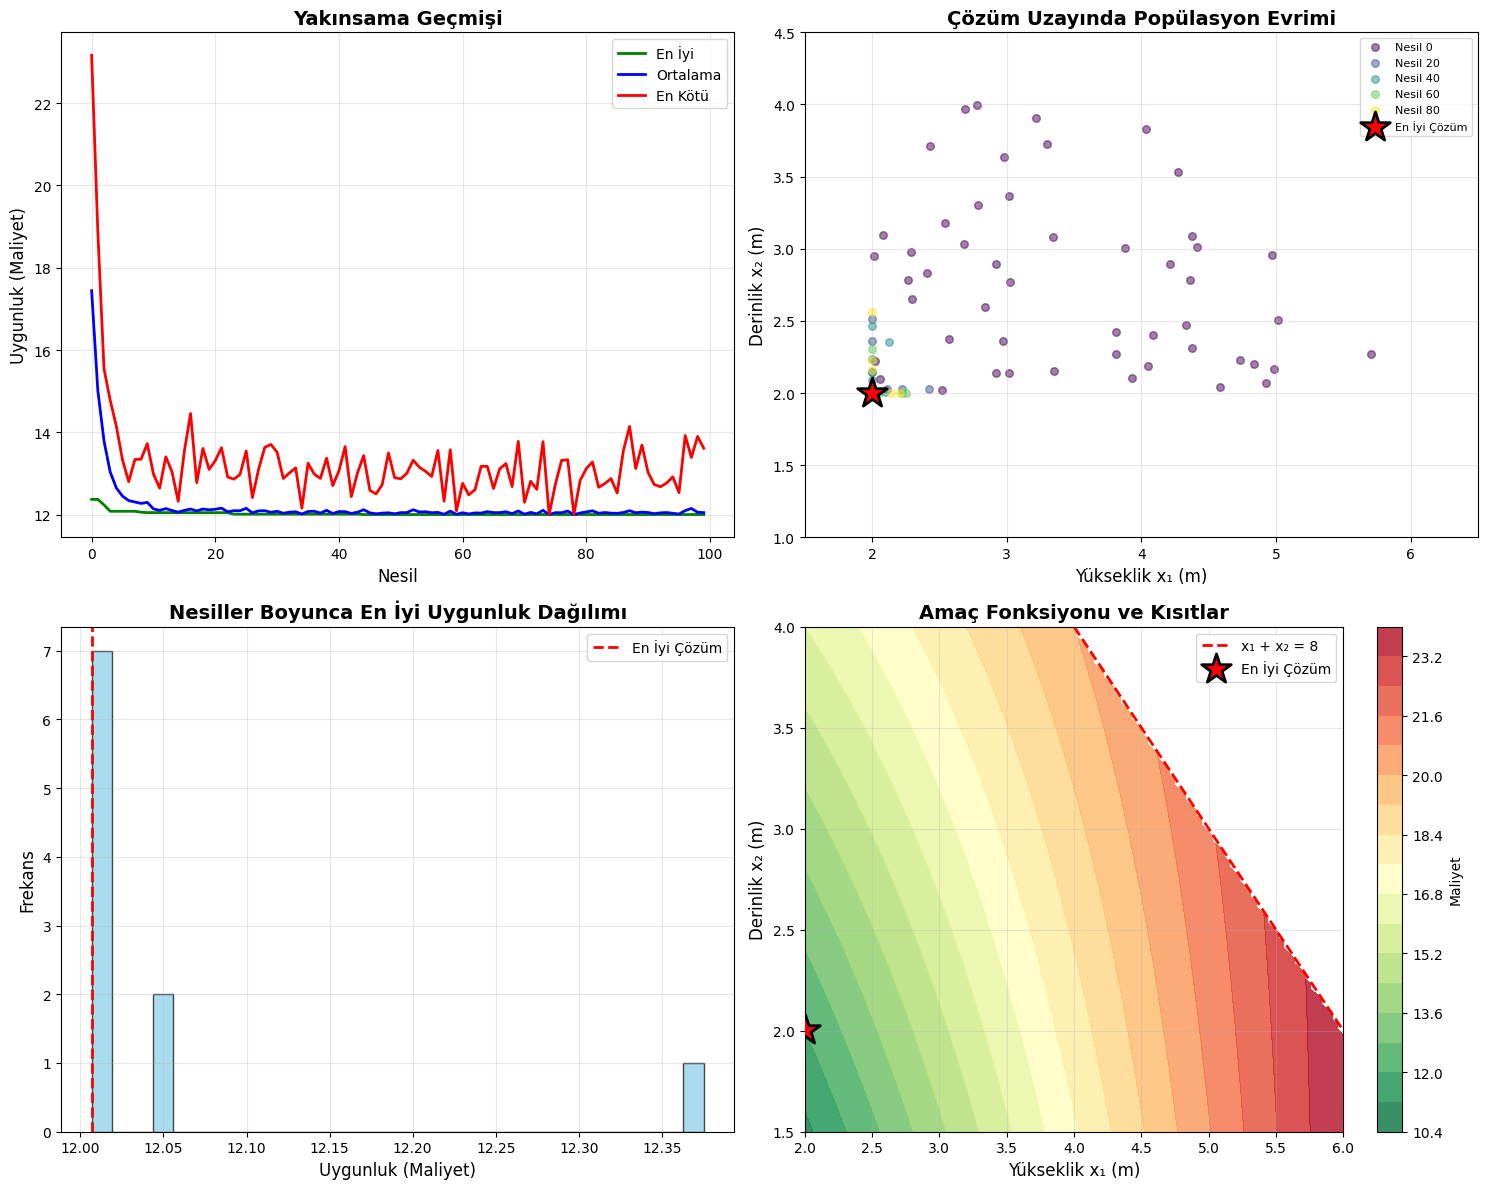



  Farklı parametre konfigürasyonları karşılaştırılıyor...

Test Ediliyor: Küçük Popülasyon
En İyi Maliyet: 12.0031

Test Ediliyor: Büyük Popülasyon
En İyi Maliyet: 12.0045

Test Ediliyor: Yüksek Mutasyon
En İyi Maliyet: 12.0003

Test Ediliyor: Düşük Mutasyon
En İyi Maliyet: 12.0053

PARAMETRE KARŞILAŞTIRMA SONUÇLARI
   Konfigürasyon  En İyi x₁  En İyi x₂  En İyi Maliyet  Süre (sn)
Küçük Popülasyon        2.0   2.001549       12.003099   0.092648
Büyük Popülasyon        2.0   2.002250       12.004501   0.579160
 Yüksek Mutasyon        2.0   2.000165       12.000329   0.281691
  Düşük Mutasyon        2.0   2.002672       12.005344   0.174608


In [29]:
if __name__ == "__main__":

    print("\n Varsayılan parametrelerle Genetik Algoritma çalıştırılıyor\n")

    ga = DepoGA(
        populasyon_boyut=50,
        generasyon_sayisi=100,
        caprazlama_orani=0.8,
        mutasyon_orani=0.1,
        turnuva_boyutu=3
    )

    sonuclar = ga.run(ayrintili=True)

    print("\n  Görselleştirmeler oluşturuluyor...")
    ga.plot_sonuclar()

    print("\n\n  Farklı parametre konfigürasyonları karşılaştırılıyor...")
    karsilastirma_df = parametre_karsilastir()